In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [38]:
df_ = pd.read_csv('dataset/HousingData.csv')
df_.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


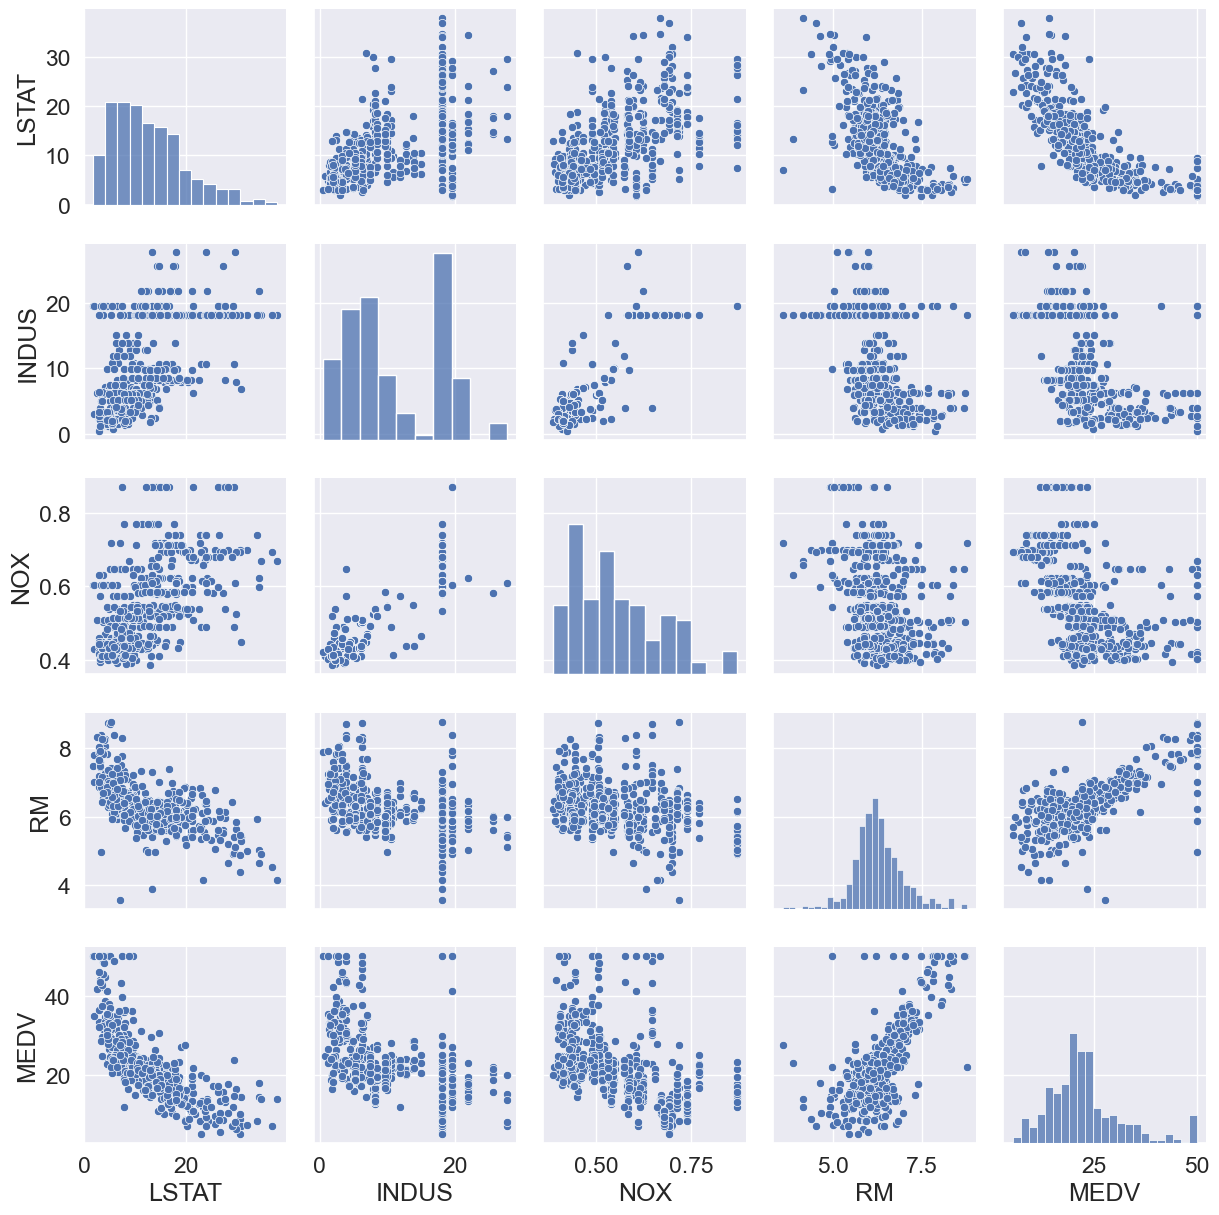

In [39]:
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
sns.pairplot(df_[cols], height=2.5)
plt.tight_layout()

In [40]:
from sklearn.impute import SimpleImputer
imr = SimpleImputer(missing_values=np.nan, strategy='mean')
imr = imr.fit(df_.values)
imputed_data = imr.transform(df_.values)

In [41]:
df = pd.DataFrame(imputed_data)
df.head()
df.columns = df_.columns
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.980000,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.140000,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.030000,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.940000,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,12.715432,36.2


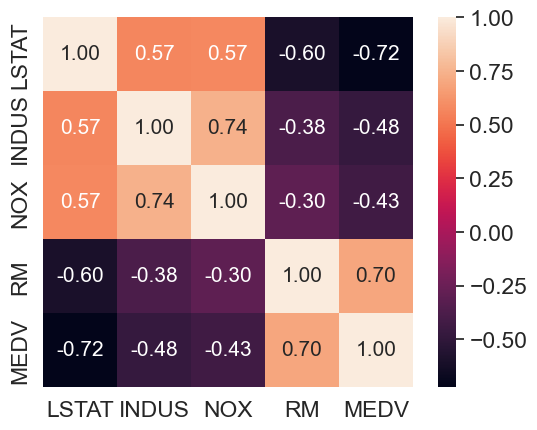

In [43]:
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, yticklabels=cols, xticklabels=cols)


In [44]:
class LinearRegressionGD(object):

    def __init__ (self, eta=0.001, n_iter=20):
        self.eta= eta
        self.n_iter = n_iter
    
    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def predict(self, X):
        return self.net_input(X)

In [53]:
X = df[['RM']].values
y = df['MEDV'].values

from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
# we add a new dimension to 'y' because the function expects the data to be in 2-D, we then again flatten the data to restore dimensionality
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

lr = LinearRegressionGD()
lr.fit(X_std, y_std)

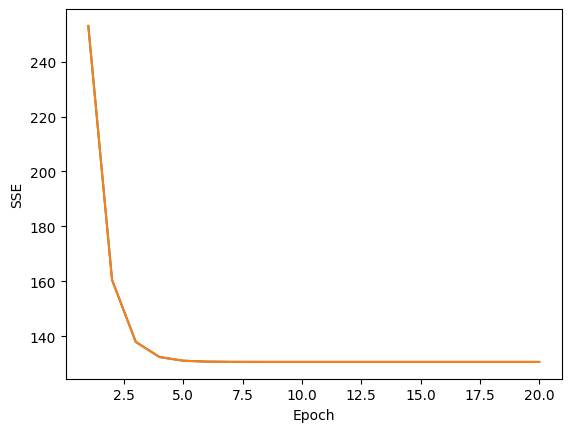

In [55]:
sns.reset_orig() # resets the matplotlib style
plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.show()

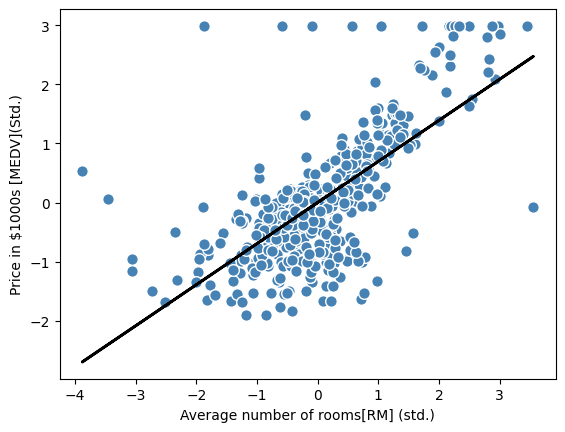

In [56]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)
    return None

lin_regplot(X_std, y_std, lr)
plt.xlabel('Average number of rooms[RM] (std.)')
plt.ylabel('Price in $1000s [MEDV](Std.)')
plt.show()

In [77]:
print('Slope: %.3f' % lr.w_[1])
print('Intercept: %.3f' % lr.w_[0])

Slope: 0.695
Intercept: -0.000


In [79]:
# answer in unstandardized terms
num_rooms_std = sc_x.transform(np.array([[5.0]]))
price_std = lr.predict(num_rooms_std)
print("Price in $1000s: %.3f" % sc_y.inverse_transform(price_std[:, np.newaxis]).flatten())

Price in $1000s: 10.840


using Scikit 

In [80]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X, y)
print('Slope: %.3f' %slr.coef_[0])
print('Intercept: %.3f' %slr.intercept_)

Slope: 9.102
Intercept: -34.671


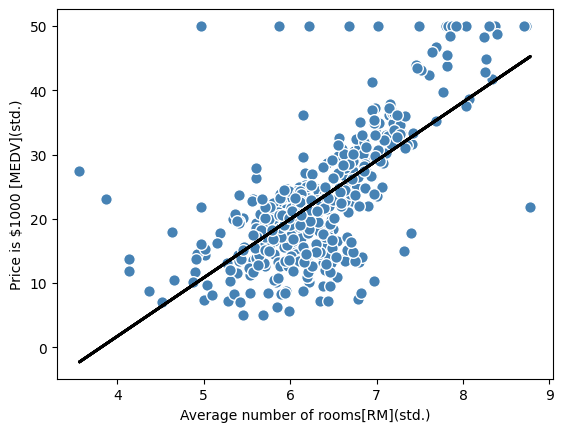

In [83]:
lin_regplot(X, y, slr)
plt.xlabel('Average number of rooms[RM](std.)')
plt.ylabel('Price is $1000 [MEDV](std.)')
plt.show()

RANdom SAmple Consesnus (RANSAC)

In [85]:
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(LinearRegression(), max_trials=100, min_samples=50, loss='absolute_error', residual_threshold=5.0, random_state=0)
ransac.fit(X, y)

RANSACRegressor(estimator=LinearRegression(), min_samples=50, random_state=0,
                residual_threshold=5.0)

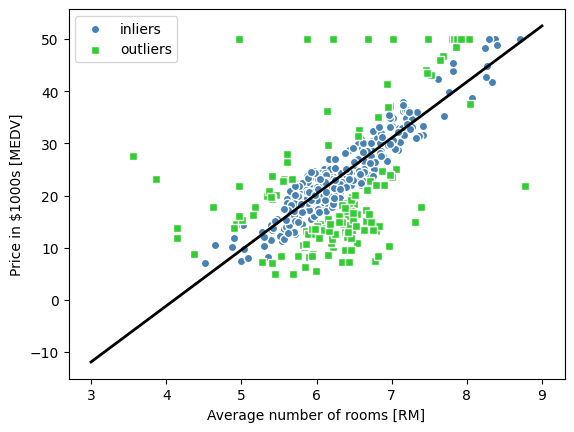

In [86]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask], c='steelblue', edgecolor='white', marker='o', label='inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], c='limegreen', edgecolor='white', marker='s', label='outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper left')
plt.show()

In [87]:
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)

Slope: 10.735
Intercept: -44.089
